In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class LeNet_naive(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes)
        )

def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

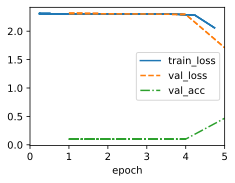

In [4]:
trainer = d2l.Trainer(max_epochs=5, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_naive(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

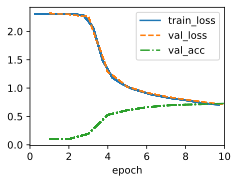

In [5]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model = LeNet_naive(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

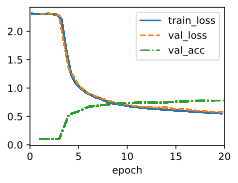

In [6]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model = LeNet_naive(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [7]:
class LeNet_modern(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

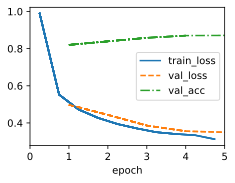

In [8]:
trainer = d2l.Trainer(max_epochs=5, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_modern(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

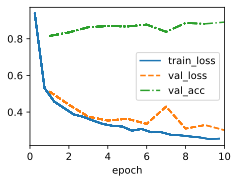

In [9]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model = LeNet_modern(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

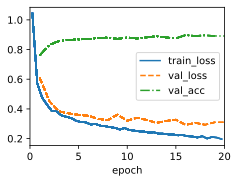

In [10]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model = LeNet_modern(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [11]:
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

class MNIST(d2l.DataModule):  #@save
    """MNIST Dataset class made myself :)"""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)
        
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                        num_workers=self.num_workers)

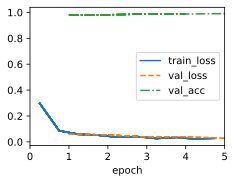

In [12]:
data = MNIST()
trainer = d2l.Trainer(max_epochs=5, num_gpus=1)
model = LeNet_modern()
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

trainer.fit(model, data)

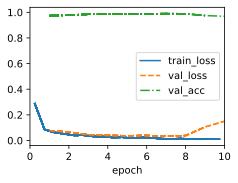

In [13]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
model = LeNet_modern()
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

trainer.fit(model, data)

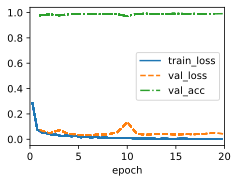

In [14]:
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
model = LeNet_modern()
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

trainer.fit(model, data)

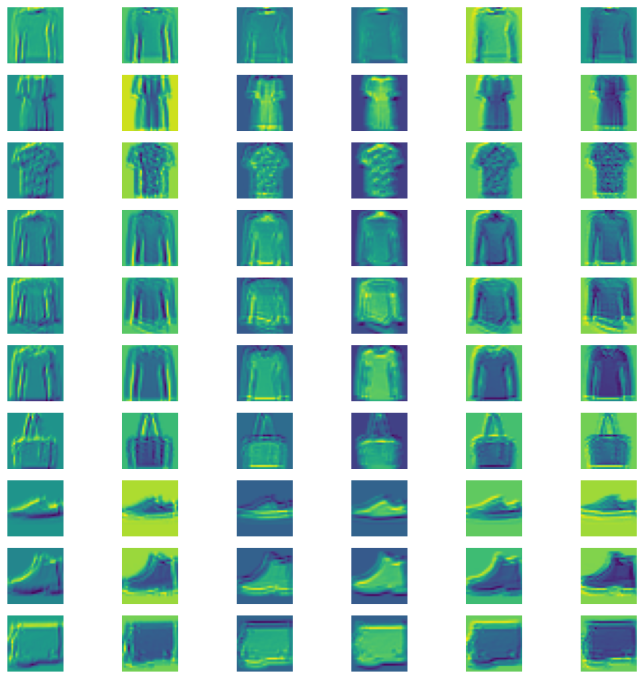

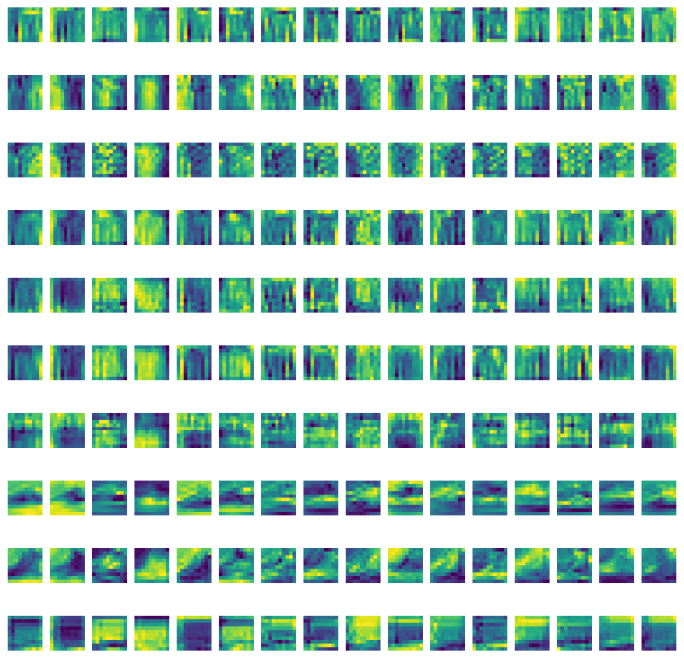

In [15]:
import matplotlib.pyplot as plt

data = d2l.FashionMNIST(batch_size=128)
model = LeNet_naive()

# Store the activations
activations = {}

# Wrapper for dictionary
def hook_wrapper(name):
    def activation_hook(model, input, output):
        activations[name] = output.detach()
    return activation_hook # I think this detaches the hook

model.net[0].register_forward_hook(hook_wrapper('Conv2d_0'))
model.net[3].register_forward_hook(hook_wrapper('Conv2d_1'))

data_iter = iter(data.get_dataloader(True))
X, y = next(data_iter) # images, labels

output = model(X[:10])

def visualize_activations(activations, layer_name, num_images=10):
    act = activations[layer_name]
    fig, axes = plt.subplots(num_images, act.size(1), figsize=(12, 12))
    for i in range(num_images):
        for j in range(act.size(1)):
            axes[i, j].imshow(act[i, j].cpu().numpy(), cmap='viridis')
            axes[i, j].axis('off')
    plt.show()

visualize_activations(activations, 'Conv2d_0')
visualize_activations(activations, 'Conv2d_1')

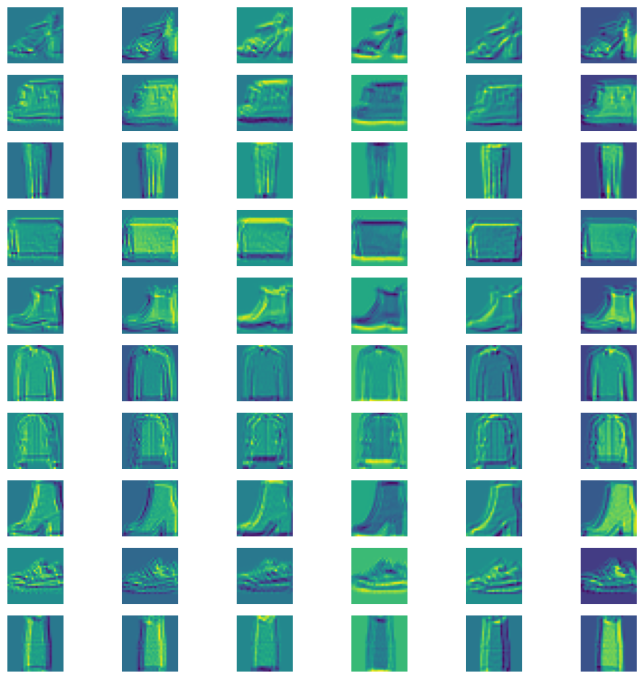

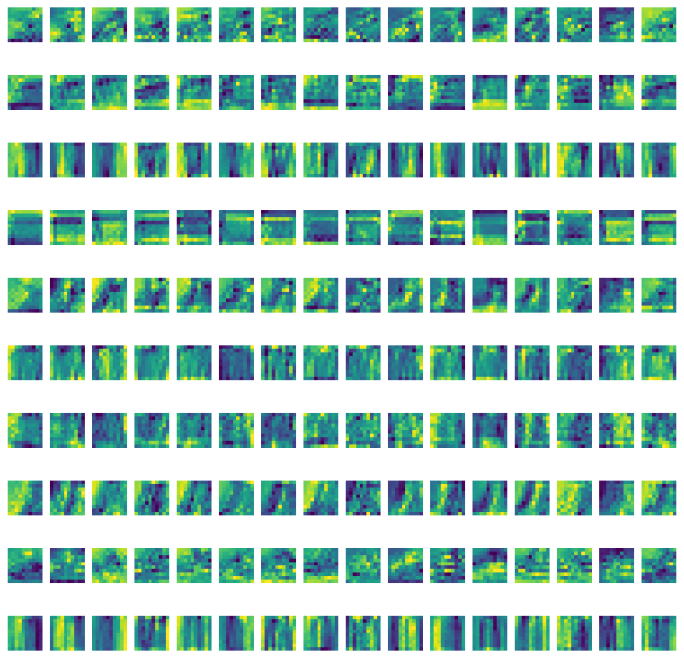

In [16]:
model = LeNet_modern()
activations = {}

model.net[0].register_forward_hook(hook_wrapper('Conv2d_0'))
model.net[3].register_forward_hook(hook_wrapper('Conv2d_1'))

data_iter = iter(data.get_dataloader(True))
X, y = next(data_iter) # images, labels

output = model(X[:10])

visualize_activations(activations, 'Conv2d_0')
visualize_activations(activations, 'Conv2d_1')

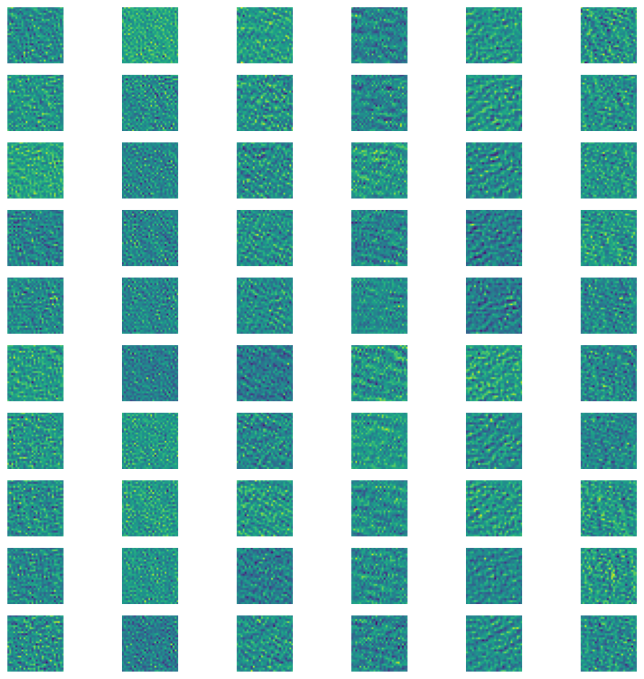

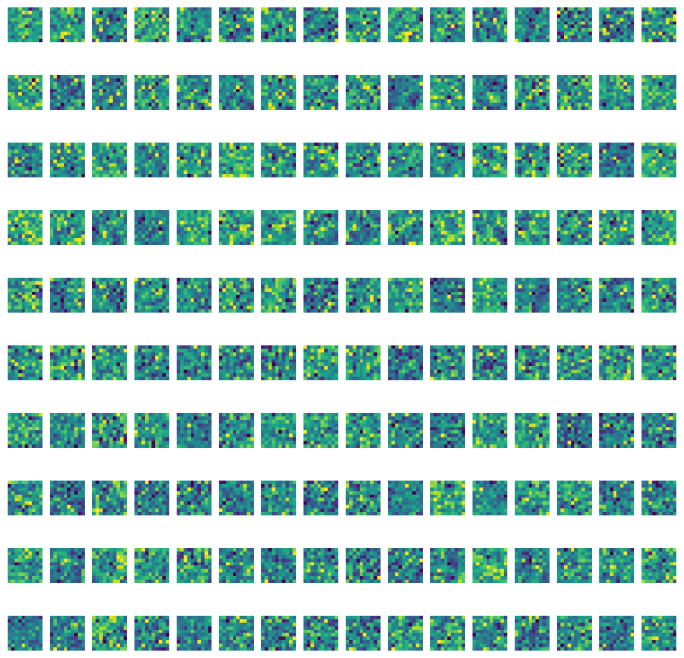

In [17]:
# Random noise activations
X = torch.randn(128, 1, 28, 28)

activations = {}
model.net[0].register_forward_hook(hook_wrapper('Conv2d_0'))
model.net[3].register_forward_hook(hook_wrapper('Conv2d_1'))

output = model(X)
visualize_activations(activations, 'Conv2d_0')
visualize_activations(activations, 'Conv2d_1')

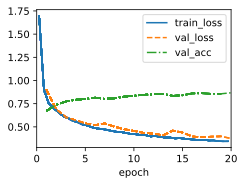

In [18]:
data = d2l.FashionMNIST(batch_size=128)
model = LeNet_modern(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

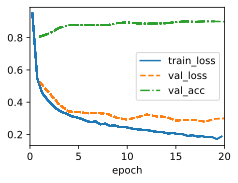

In [19]:
model = LeNet_modern(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

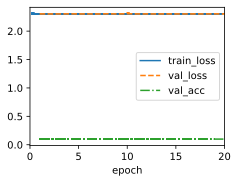

In [20]:
model = LeNet_modern(lr=1.0)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

In [21]:
# Batch normalization

def batch_normalizaiton(X, gamma, beta):
    # BN(x) = gamma * (x - mu) / sqrt(sigma^2 + epsilon) + beta
    # mu = 1/|B| * sum(x)
    # sigma^2 = 1/|B| * sum(x-mu)^2 + epsilon
    # gamma and beta are learnable parameters
    # epsilon is a small constant to prevent division by zero
    # B is the mini-batch

    # Compute the mean and variance of the input
    mu = X.mean(dim=0)
    sigma = ((X - mu) ** 2).mean(dim=0)

    # epsilon = 1e-6
    BN = gamma * (X - mu) / torch.sqrt(sigma + 1e-6) + beta
    return BN


class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2: # Fully connected layer
            shape = (1, num_features)
        else: # Convolutional layer
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

    # Abstracted batch_normalization method to be part of the forward pass of this class
    def forward(self, X): 
        if X.dim() not in (2, 4):
            raise ValueError('only 2D and 4D are supported')
        if X.dim() == 2: # Fully connected layer
            mean = X.mean(dim=0)
            sigma = ((X - mean) ** 2).mean(dim=0)
        else: # Convolutional layer
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            sigma = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = self.gamma * (X - mean) / torch.sqrt(sigma + 1e-6) + self.beta
        return X_hat

In [22]:
class LeNetBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), BatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), BatchNorm(120, num_dims=2), nn.ReLU(),
            nn.LazyLinear(84), BatchNorm(84, num_dims=2), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

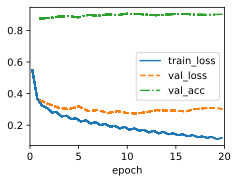

In [23]:
model = LeNetBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

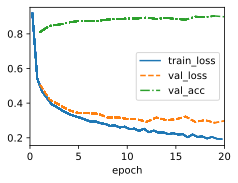

In [24]:
model = LeNet_modern(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

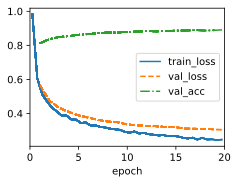

In [25]:
model = LeNetBatchNorm(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

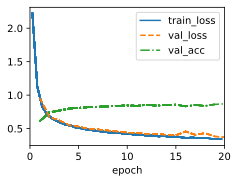

In [26]:
model = LeNet_modern(lr=0.01)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

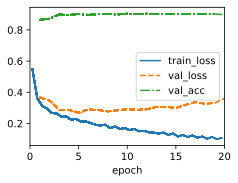

In [27]:
model = LeNetBatchNorm(lr=1.0)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

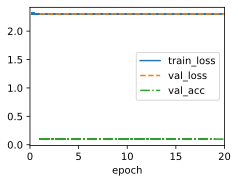

In [28]:
model = LeNet_modern(lr=1.0)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

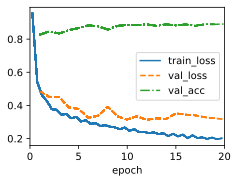

In [29]:
model = LeNetBatchNorm(lr=4.85)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

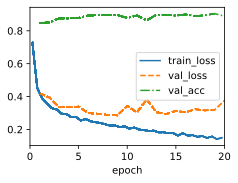

In [30]:
# Ablation study
class LeNetBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), BatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

model = LeNetBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

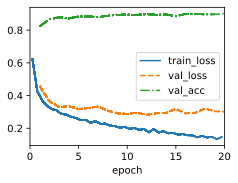

In [31]:
class LeNetBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), BatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

model = LeNetBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

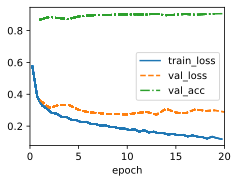

In [32]:
class LeNetBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), BatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), BatchNorm(120, num_dims=2), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

model = LeNetBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

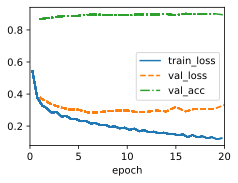

In [33]:
class LeNetBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), BatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), BatchNorm(120, num_dims=2), nn.ReLU(),
            nn.LazyLinear(84), BatchNorm(84, num_dims=2), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

model = LeNetBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

In [41]:
class MeanOnlyBatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2: # Fully connected layer
            shape = (1, num_features)
        else: # Convolutional layer
            shape = (1, num_features, 1, 1)
        
    def forward(self, X):
        if X.dim() not in (2, 4):
            raise ValueError('only 2D and 4D are supported')
        if X.dim() == 2:
            mean = X.mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
        return X - mean

class VarOnlyBatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2: # Fully connected layer
            shape = (1, num_features)
        else: # Convolutional layer
            shape = (1, num_features, 1, 1)
    
    def forward(self, X):
        if X.dim() not in (2, 4):
            raise ValueError('only 2D and 4D are supported')
        if X.dim() == 2:
            std = X.std(dim=0, keepdim=True, unbiased=False) + 1e-6
        else:
            std = X.std(dim=(0, 2, 3), keepdim=True, unbiased=False) + 1e-6
        return X / std

In [42]:
class LeNetMeanOnlyBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), MeanOnlyBatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), MeanOnlyBatchNorm(16, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), MeanOnlyBatchNorm(120, num_dims=2), nn.ReLU(),
            nn.LazyLinear(84), MeanOnlyBatchNorm(84, num_dims=2), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

class LeNetVarOnlyBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), VarOnlyBatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), VarOnlyBatchNorm(16, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), VarOnlyBatchNorm(120, num_dims=2), nn.ReLU(),
            nn.LazyLinear(84), VarOnlyBatchNorm(84, num_dims=2), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )

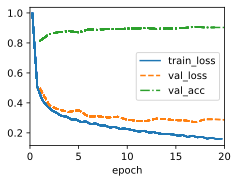

In [43]:
model = LeNetMeanOnlyBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

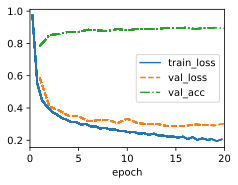

In [44]:
model = LeNetVarOnlyBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

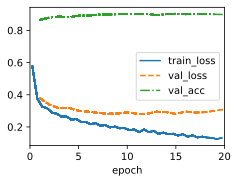

In [46]:
# Reference for comparison
model = LeNetBatchNorm(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)

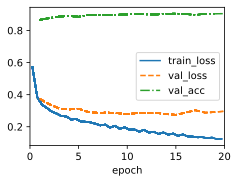

In [34]:
# Fix beta and gamma
class FixedBatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2: # Fully connected layer
            shape = (1, num_features)
        else: # Convolutional layer
            shape = (1, num_features, 1, 1)
        self.register_buffer('gamma', torch.ones(shape)) # Fix the parameters using register_buffer
        self.register_buffer('beta', torch.zeros(shape))

    # Abstracted batch_normalization method to be part of the forward pass of this class
    def forward(self, X): 
        if X.dim() not in (2, 4):
            raise ValueError('only 2D and 4D are supported')
        if X.dim() == 2: # Fully connected layer
            mean = X.mean(dim=0)
            sigma = ((X - mean) ** 2).mean(dim=0)
        else: # Convolutional layer
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            sigma = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = self.gamma * (X - mean) / torch.sqrt(sigma + 1e-6) + self.beta
        return X_hat

class LeNetBatchNorm(d2l.Classifier):    
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), FixedBatchNorm(6, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), FixedBatchNorm(16, num_dims=4), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), FixedBatchNorm(120, num_dims=2),  nn.ReLU(),
            nn.LazyLinear(84), FixedBatchNorm(84, num_dims=2), nn.ReLU(),
            nn.LazyLinear(num_classes)
        )
        

model = LeNetBatchNorm()
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer = d2l.Trainer(max_epochs=20, num_gpus=1)
trainer.fit(model, data)